# Project 2: Supervised Learning
### Building a Student Intervention System

## 1. Classification vs Regression

Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?

ANSWER: This is a problem of classification because we need to have a discrete prediction for each student. In other words we will predict whether a student will drop out or graduate from high school. 

## 2. Exploring the Data

Let's go ahead and read in the student dataset first.

_To execute a code cell, click inside it and press **Shift+Enter**._

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import time
from __future__ import division
from sklearn import grid_search, metrics,neighbors,cross_validation, svm

In [2]:
# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"
# Note: The last column 'passed' is the target/label, all other are feature columns

Student data read successfully!


Now, can you find out the following facts about the dataset?
- Total number of students
- Number of students who passed
- Number of students who failed
- Graduation rate of the class (%)
- Number of features

_Use the code block below to compute these values. Instructions/steps are marked using **TODO**s._

In [3]:
# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
#print student_data
student_data_shape = np.shape(student_data)
n_students = student_data_shape[0]
n_features = student_data_shape[1]-1 #-1 is necessary in order to adjust for the presence of target column
n_passed = np.shape(student_data[student_data['passed']=='yes'])[0]
n_failed = np.shape(student_data[student_data['passed']=='no'])[0]
grad_rate = n_passed/n_students*100 
print "Total number of students: {}".format(n_students)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 30
Graduation rate of the class: 67.09%


## 3. Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.

In [4]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print "Feature column(s):-\n{}".format(feature_cols)
print "Target column: {}".format(target_col)

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels
print "\nFeature values:-"
print X_all.head()  # print the first 5 rows

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Target column: passed

Feature values:-
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...    

### Preprocess feature columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [5]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)
print "Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we split the data (both features and corresponding labels) into training and test sets.

In [19]:
# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
num_train = 300  # about 75% of the data
num_test = num_all - num_train
test_size_value = num_test/num_all
# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_all, y_all, test_size=test_size_value, random_state=0)
print X_train.tail()
print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])
# Note: If you need a validation set, extract it from within training data

     school_GP  school_MS  sex_F  sex_M  age  address_R  address_U  \
323        1.0        0.0    1.0    0.0   17        0.0        1.0   
192        1.0        0.0    0.0    1.0   17        0.0        1.0   
117        1.0        0.0    0.0    1.0   16        0.0        1.0   
47         1.0        0.0    0.0    1.0   16        0.0        1.0   
172        1.0        0.0    0.0    1.0   17        0.0        1.0   

     famsize_GT3  famsize_LE3  Pstatus_A    ...     higher  internet  \
323          1.0          0.0        0.0    ...          1         1   
192          1.0          0.0        0.0    ...          1         1   
117          1.0          0.0        0.0    ...          1         1   
47           1.0          0.0        0.0    ...          1         1   
172          0.0          1.0        0.0    ...          1         1   

     romantic  famrel  freetime  goout  Dalc  Walc  health  absences  
323         0       3         4      3     2     3       5         1  
192 

## 4. Training and Evaluating Models
Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem. For each model:

- What are the general applications of this model? What are its strengths and weaknesses?
- Given what you know about the data so far, why did you choose this model to apply?
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

Note: You need to produce 3 such tables - one for each model.

In [7]:
# Train a model
def train_classifier(clf, X_train, y_train):
    print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print "Done!\nTraining time (secs): {:.15f}".format(end - start)

# TODO: Choose a model, import it and instantiate an object
from sklearn import tree
clf = tree.DecisionTreeClassifier()

# Fit model to training data
train_classifier(clf, X_train, y_train)  # note: using entire training set here
#print clf  # you can inspect the learned model by printing it

Training DecisionTreeClassifier...
Done!
Training time (secs): 0.008000135421753


In [8]:
# Predict on training set and compute F1 score
def predict_labels(clf, features, target):
    print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    print "Done!\nPrediction time (secs): {:.15f}".format(end - start)
    return metrics.f1_score(target.values, y_pred, pos_label='yes')

train_f1_score = predict_labels(clf, X_train, y_train)
print "F1 score for training set: {}".format(train_f1_score)

Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.026000022888184
F1 score for training set: 1.0


In [9]:
# Predict on test data
print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test))

Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.001000165939331
F1 score for test set: 0.72131147541


In [10]:
# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):
    print "------------------------------------------"
    print "Training set size: {}".format(len(X_train))
    train_classifier(clf, X_train, y_train)
    print "F1 score for training set: {}".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test))

# TODO: Run the helper function above for desired subsets of training data
# Note: Keep the test set constant
train_predict(clf, X_train[:100], y_train[:100], X_test, y_test)
train_predict(clf, X_train[:200], y_train[:200], X_test, y_test)
train_predict(clf, X_train[:300], y_train[:300], X_test, y_test)


------------------------------------------
Training set size: 100
Training DecisionTreeClassifier...
Done!
Training time (secs): 0.000999927520752
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.000000000000000
F1 score for training set: 1.0
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.000000000000000
F1 score for test set: 0.697247706422
------------------------------------------
Training set size: 200
Training DecisionTreeClassifier...
Done!
Training time (secs): 0.001999855041504
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.000000000000000
F1 score for training set: 1.0
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.000000000000000
F1 score for test set: 0.730158730159
------------------------------------------
Training set size: 300
Training DecisionTreeClassifier...
Done!
Training time (secs): 0.002000093460083
Predicting labels using Decis

In [11]:
# TODO: Train and predict using two other models
clf = svm.SVC()
train_predict(clf, X_train[:100], y_train[:100], X_test, y_test)
train_predict(clf, X_train[:200], y_train[:200], X_test, y_test)
train_predict(clf, X_train[:300], y_train[:300], X_test, y_test)

------------------------------------------
Training set size: 100
Training SVC...
Done!
Training time (secs): 0.049000024795532
Predicting labels using SVC...
Done!
Prediction time (secs): 0.001000165939331
F1 score for training set: 0.859060402685
Predicting labels using SVC...
Done!
Prediction time (secs): 0.000999927520752
F1 score for test set: 0.783783783784
------------------------------------------
Training set size: 200
Training SVC...
Done!
Training time (secs): 0.003999948501587
Predicting labels using SVC...
Done!
Prediction time (secs): 0.003000020980835
F1 score for training set: 0.869281045752
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002000093460083
F1 score for test set: 0.775510204082
------------------------------------------
Training set size: 300
Training SVC...
Done!
Training time (secs): 0.009000062942505
Predicting labels using SVC...
Done!
Prediction time (secs): 0.006000041961670
F1 score for training set: 0.869198312236
Predicting labels u

In [12]:
# TODO: Train and predict using two other models

clf = neighbors.KNeighborsClassifier()
train_predict(clf, X_train[:100], y_train[:100], X_test, y_test)
train_predict(clf, X_train[:200], y_train[:200], X_test, y_test)
train_predict(clf, X_train[:300], y_train[:300], X_test, y_test)

------------------------------------------
Training set size: 100
Training KNeighborsClassifier...
Done!
Training time (secs): 0.070999860763550
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.002000093460083
F1 score for training set: 0.797202797203
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.002000093460083
F1 score for test set: 0.706766917293
------------------------------------------
Training set size: 200
Training KNeighborsClassifier...
Done!
Training time (secs): 0.001000165939331
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.003999948501587
F1 score for training set: 0.857142857143
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.003000020980835
F1 score for test set: 0.712121212121
------------------------------------------
Training set size: 300
Training KNeighborsClassifier...
Done!
Training time (secs): 0.001999855041504
Predicting labels usi

In [13]:
data = {'labels': ['Size_100', 'Size_200', 'Size_300'],
            'Train_times': [0.001,0.001,0.001],
            'Predtime_train': [0,0.001,0],
            'Predtime_test': [0,0.001,0],
            'F1_train': [1,1,1],
            'F1_test': [0.69,0.74,0.70]}
DT_data = pd.DataFrame(data)
print 'Performance for DT:'
print DT_data
data = {'labels': ['Size_100', 'Size_200', 'Size_300'],
            'Train_times': [0.001,0.001,0.001],
            'Predtime_train': [0.001,0.003,0.007],
            'Predtime_test': [0.002,0.002,0.003],
            'F1_train': [0.80,0.860,0.87],
            'F1_test': [0.71,0.71,0.75]}
KNN_data = pd.DataFrame(data)
print 'Performance for KNN:'
print KNN_data
data = {'labels': ['Size_100', 'Size_200', 'Size_300'],
            'Train_times': [0.001,0.005,0.007],
            'Predtime_train': [0.001,0.003,0.006],
            'Predtime_test': [0.001,0.001,0.002],
            'F1_train': [0.859,0.869,0.869],
            'F1_test': [0.784,0.775,0.758]}
SVM_data = pd.DataFrame(data)
print 'Performance for SVM:'
print SVM_data

Performance for DT:
   F1_test  F1_train  Predtime_test  Predtime_train  Train_times    labels
0     0.69         1          0.000           0.000        0.001  Size_100
1     0.74         1          0.001           0.001        0.001  Size_200
2     0.70         1          0.000           0.000        0.001  Size_300
Performance for KNN:
   F1_test  F1_train  Predtime_test  Predtime_train  Train_times    labels
0     0.71      0.80          0.002           0.001        0.001  Size_100
1     0.71      0.86          0.002           0.003        0.001  Size_200
2     0.75      0.87          0.003           0.007        0.001  Size_300
Performance for SVM:
   F1_test  F1_train  Predtime_test  Predtime_train  Train_times    labels
0    0.784     0.859          0.001           0.001        0.001  Size_100
1    0.775     0.869          0.001           0.003        0.005  Size_200
2    0.758     0.869          0.002           0.006        0.007  Size_300


## General Discussion for each Model:
### Decision Tree Algorithm: 
Decision trees create a model or a tree that predicts the value of a target variable(in this cassed passed) by learning simple decision rules from the data. For example in our data set it is most likely that children with only one guardian are more likely to drop out of school. In this case a simple decision tree with one node would classify pupils as dropouts if one of the guardian variables are zero.
#### Advantages and Disadvantages of Decision Trees:
Decision trees have many advantages. First of all they can be easiliy visualized. This is not possible in case of many other algorithms. For example, in SVM, it is basically impossible for us to imagine data in 10 dimensional space. Secondly, they have logarithmic run times, therefore they are very fast. When examining the performance table above you can see that they are the fastest. Another advantage would be that decision trees can use categorical data even without any formating, however in our examples we are already preprocessing data, so we are taking advantage of this feature.

Several disadvantages exist. First it is easy to see from the performance table that the decision tree that we have created is overfitting and there is huge difference between F1 scores of training and testing data sets. Second disadvantage is that decision trees do not perform well if one the classes dominates, but I think in this case it is 30% vs. 70%, so they are roughly equal.

Given this discussion, I tried decision trees for this particular problem because they are usually used for classification, easy to understand and visualize and suitable for our data where most of the features are categorical.
### Support Vector Machines: 
Support vector machines are a set of classifiers that try to find the optimum linear seperator between two classes. Although in reality most data would not be linearly seperable, SVM uses a kernel trick that adds news features into the data by combining existing features in various ways. For example a set of data points containing x and y features may not be linearly seperable in two dimensional space, but they may be in three dimensional space where x^2+y^2 is the third variable.
#### Advantages and Disadvantages of Support Vector Machines:
There are two advantages of using support vector machines. One is that they use only a small subset of data in order to train model and they are called support vectors. This is a more memory efficient method in situations where we have tons of data. A second advantage is that they are robust in cases where the number of data points are on the order of the number of features. In other words they suffer less from the curse of dimensionality.

There may be two disadvanges. One is that it may difficult to explain how they work. The concept of high dimensionalty may be difficult to grasp. SVM also does not work when the number of features are much bigger than data, but this is rarely the case.
I think it is suitable in this case because it is a widely used classification algorithm that performs best right out of the box.
### K nearest neighbours algorithm: 
Classifiction based on nearest neighbours algorithm is one where no explicit model for the data is constructed. Classifier simply stores the data and whenever a new point comes, classifier assings the new point to a class based on its closest k neighbours.
#### Advantages and Disadvantages of KNN:
The main advantage of KNN is that training times are short. There is essentially no training and no model. Therefore it is easy to update KNN as the new data comes.  Another advantage is that it will be very easy to explaing this model in laymen's terms. However the disadvantage is that predicting each new data point takes a long time. For each data point we have to calculate its nearest neighbours. Another disadvantage is the curse of dimensionality as explaing by Charles Isbell during the lectures. As the dimensions of the feature space increases each data point is going to represent a bigger volume of space for which it may not be representative. 
I wanted to try KNN also as it is a very simple algorithms that makes no assumption about the data.


## 5. Choosing the Best Model

- Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?
- In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).
- Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.
- What is the model's final F<sub>1</sub> score?

#### Justification for the final model:

Based on the experiments I have done, I have settled on a SVM algorithm. First reason is the F1 score on the test data. Among three algorithms, SVM gave the highest F1 score on the test data without needing any optimization. Although DT scores are higher on the training data, this is an example of overfitting as we do not see the same performance on the test set. In terms of computational costs decision tree has the lowest cost, but the scores are the worst. Computational costs of KNN and SVM are very similar. KNN has lower cost on the training, but SVM has lower cost on the prediction times. This is normal as KNN is an instance based learning and does not build a model of the data, therefore it is faster on the training. Final decision would be depend on actual costs of training vs prediction, but assuming that they are equal, I chose SVM given its superior performance.

Final F1 score for my optimized model was 79.1%.

#### How do Suppor vector machines work?

Support vector machines try to find the best line seperating two classes of data. The best line is the one where it is exactly in the middle of support lines(See figure A). And support lines are ones that classify the data correclty by barely touching a couple of data points. Because SVM uses not the whole data but some points during this process and these points support the support lines, the points are called support vectors and the algorithm is called support vector machines. Although we cannot seperate most data points linearly in real world(see figure B), SVM adds new features to the data by combining the existing features  in order to make the data seperable. This is called the kernel trick. For example a set of data points containing x and y features may not be linearly seperable , but they may be seperable if we do the kernel trick and add a new feature that quantifies their distance from the origin(see figure C). 

SVMs make a decision by first transforming any given data point into higher dimensional space, which is simply calculating the values of features decided during the kernel trick. Now we simply look at whether a new data point falls into which side of the line. If it falls on the side with future graduates we classifity it as a future graduate. If it falls on the other side, we classifity it as a dropout. For example blue data in the Figure A falls on the upper side of the line with the green points, therefore it is classified as green.


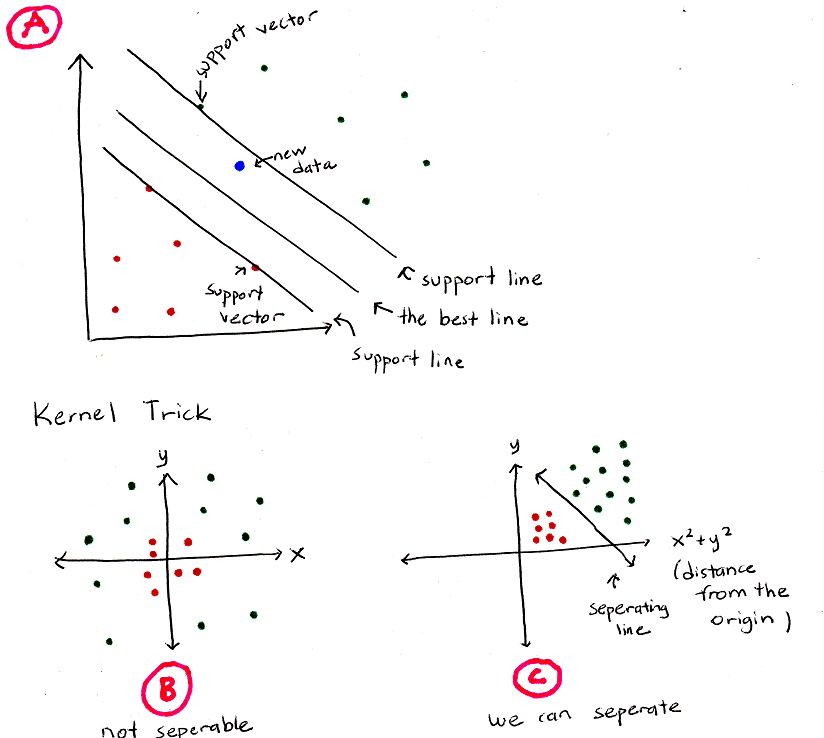

In [14]:
from IPython.display import Image
Image("SVM.png")

In [15]:
# TODO: Fine-tune your model and report the best F1 score
#Find the best parameters
scoring_function = metrics.make_scorer(metrics.accuracy_score)
parameters = {'max_depth':[3, 4, 5, 6, 7],'min_samples_split':[6, 8, 10, 12, 14, 16]}
tree_clf = tree.DecisionTreeClassifier()
optimum_tree = grid_search.GridSearchCV(tree_clf, parameters,scoring_function)
optimum_tree.fit(X_train, y_train) 
print optimum_tree.best_params_

#Print the F1 score for the optimum tree
y_pred = optimum_tree.predict(X_test)
print metrics.f1_score(y_test.values, y_pred,pos_label='yes')

clf = tree.DecisionTreeClassifier(max_depth=3,min_samples_split=12)
clf.fit(X_train,y_train)
tree.export_graphviz(clf,out_file='tree.dot')

{'min_samples_split': 16, 'max_depth': 6}
0.748091603053


In [16]:
#Some optimization for KNN
# TODO: Fine-tune your model and report the best F1 score
#Find the best parameters
scoring_function = metrics.make_scorer(metrics.accuracy_score)
parameters = {'n_neighbors':[3, 4, 5, 6, 7, 8, 9, 10]}
knn_clf = neighbors.KNeighborsClassifier()
optimum_tree = grid_search.GridSearchCV(knn_clf, parameters,scoring_function)
optimum_tree.fit(X_train, y_train) 
print optimum_tree.best_params_

#Print the F1 score for the optimum tree
y_pred = optimum_tree.predict(X_test)
print metrics.f1_score(y_test.values, y_pred,pos_label='yes')

{'n_neighbors': 9}
0.797202797203


In [17]:
#Some optimization for SVM
# TODO: Fine-tune your model and report the best F1 score

#Find the best parameters
scoring_function = metrics.make_scorer(metrics.accuracy_score)
parameters = {'kernel':['linear', 'poly', 'rbf', 'sigmoid', ], 'C':[0.4,0.6,0.8,1], 'gamma':[0.01,0.1,0.2,0.5,1]}
new_clf = svm.SVC()
optimum_tree = grid_search.GridSearchCV(new_clf, parameters,scoring_function)
optimum_tree.fit(X_train, y_train) 
print optimum_tree.best_params_

#Print the F1 score for the optimum tree
y_pred = optimum_tree.predict(X_test)
print metrics.f1_score(y_test.values, y_pred,pos_label='yes')

{'kernel': 'rbf', 'C': 1, 'gamma': 0.1}
0.791946308725
